In [1]:
import numpy as np
import matplotlib.pyplot as plt
import  warnings
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [2]:
warnings.filterwarnings('ignore')

In [3]:
class CNN(nn.Module):
    def __init__(
            self, 
            in_channels:int=1, 
            out_channel=8, 
            kernel_size:tuple[int,int]=(3,3), 
            stride:tuple[int,int]=(1,1), 
            padding:tuple[int,int]=(1,1), 
            num_classes:int=10,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channel,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.pool = nn.MaxPool2d(
            kernel_size=(2,2),
            stride=(2,2)
        )
        self.conv2 = nn.Conv2d(
            in_channels=out_channel,
            out_channels=out_channel * 2,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.fc1 = nn.Linear((out_channel * 2) * 7 * 7, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x
        

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu:0")
in_channels = 1
num_classes = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 1

In [5]:
# load data
train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transforms.ToTensor(), download=True)

In [6]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [7]:
model = CNN(in_channels=in_channels, num_classes=num_classes).to(device)
# loss functions
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Put the model in training mode
model.train()

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [9]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    for batch_idx, (data, targets) in enumerate(train_loader):
        # set the data to device
        data = data.to(device)
        targets = targets.to(device)
        
        scores = model(data)
        loss = criterion(scores, targets)
        # backward
        optimizer.zero_grad() # set all gradients to zero for each batch to avoid storing batch forward calculation
        loss.backward()
        # gradient descent or adam step
        optimizer.step() 
        # add the training loss to the train loses
        train_losses.append(loss.item())
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # set the model to validation mode
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                prediction = model(x)
                val_loss += criterion(prediction, y).item()
        
        val_loss /= len(test_loader)  # Average validation loss
        val_losses.append(val_loss)
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

print("Training and validation completed.")

Epoch [1/1], Step [0/938], Loss: 2.3083
Epoch [1/1], Validation Loss: 2.3063
Epoch [1/1], Step [100/938], Loss: 0.4788
Epoch [1/1], Validation Loss: 0.4412
Epoch [1/1], Step [200/938], Loss: 0.2663
Epoch [1/1], Validation Loss: 0.2754
Epoch [1/1], Step [300/938], Loss: 0.2180
Epoch [1/1], Validation Loss: 0.2189
Epoch [1/1], Step [400/938], Loss: 0.1123
Epoch [1/1], Validation Loss: 0.1847
Epoch [1/1], Step [500/938], Loss: 0.1264
Epoch [1/1], Validation Loss: 0.1476
Epoch [1/1], Step [600/938], Loss: 0.1603
Epoch [1/1], Validation Loss: 0.1423
Epoch [1/1], Step [700/938], Loss: 0.2327
Epoch [1/1], Validation Loss: 0.1234
Epoch [1/1], Step [800/938], Loss: 0.1419
Epoch [1/1], Validation Loss: 0.1071
Epoch [1/1], Step [900/938], Loss: 0.1817
Epoch [1/1], Validation Loss: 0.0923
Training and validation completed.


In [10]:
model_path = "../models/cnn.pth"

In [11]:
# save the model
torch.save(model.state_dict(), model_path)

In [12]:
model.load_state_dict(torch.load(model_path))
model.eval()

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=784, out_features=10, bias=True)
)

In [13]:
x = np.arange(1, len(train_losses) + 1)

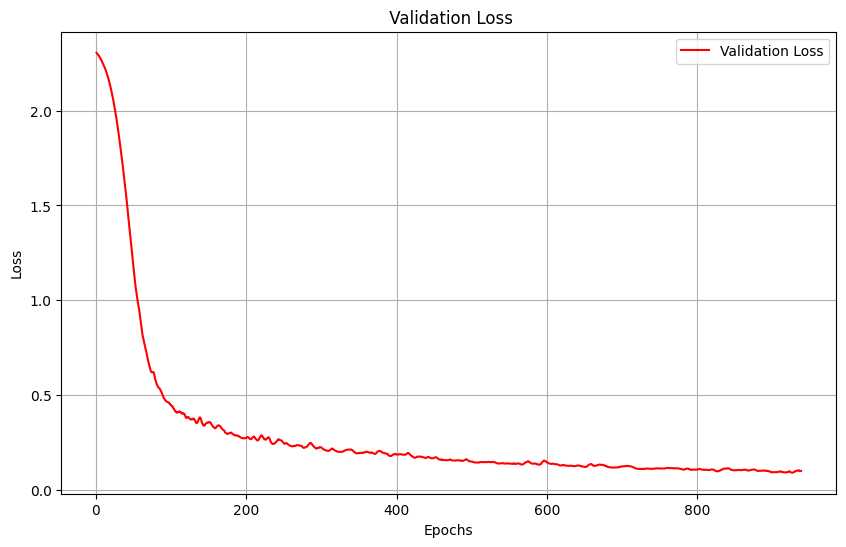

In [14]:
# plot the validation loss
plt.figure(figsize=(10, 6))
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(" Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

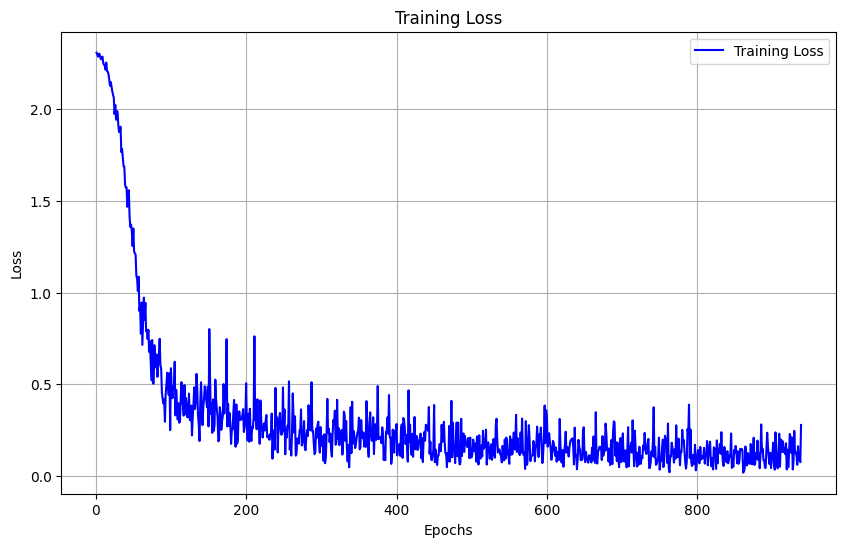

In [15]:
# plot the training
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()
plt.show()

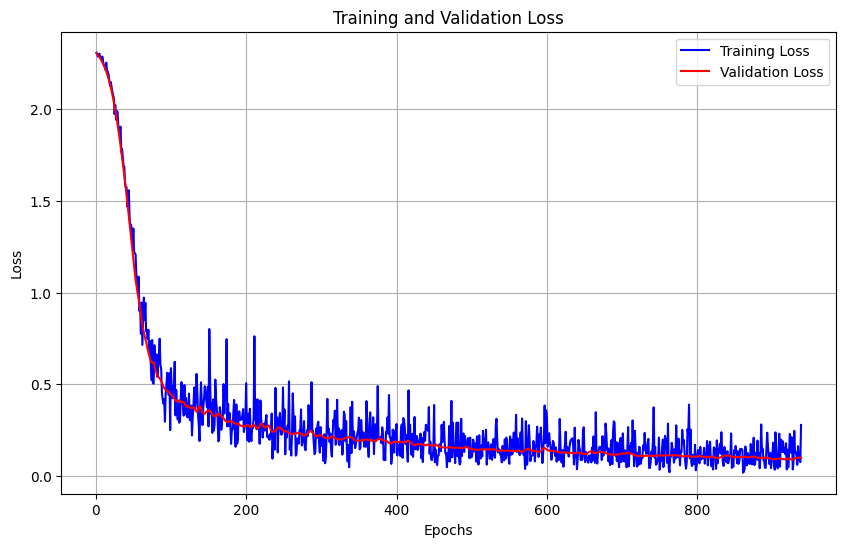

In [16]:
# plot the training and validation loss 
plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label="Training Loss", color='blue')
plt.plot(x, val_losses, label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
# check for the accuracy of the model
def check_accuracy(loader, trained_model):
    num_correct = 0
    num_samples = 0
    trained_model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            pred_scores = trained_model(x)
            _, predictions = pred_scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)
            
    print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100}")
    print(f"Accuracy: {float(num_correct)/float(num_samples)*100}")

In [20]:
check_accuracy(test_loader, model)

Got 9707 / 10000 with accuracy 97.07000000000001
Accuracy: 97.07000000000001
